# 微调

In [1]:
import torch
from torch import nn
from d2l import torch as d2l
import os
import torchvision

In [2]:
d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL + 'hotdog.zip', 'fba480ffa8aa7e0febbb511d181409f899b9baa5')

In [3]:
data_dir = d2l.download_extract('hotdog')

In [4]:
train_images = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'))
test_images = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'))

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

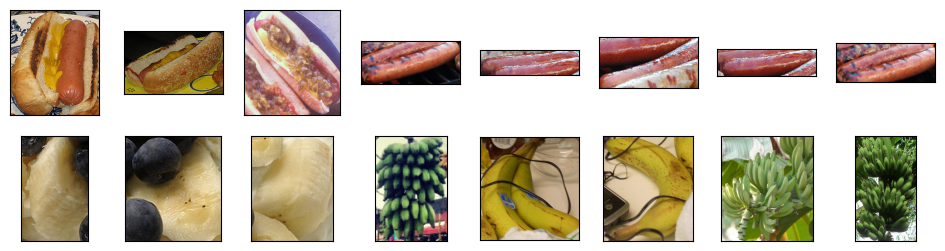

In [5]:
hot_dogs = [train_images[i][0] for i in range(8)]
not_hot_dogs = [train_images[-i-1][0] for i in range(8)]
d2l.show_images(hot_dogs + not_hot_dogs, 2, 8)

In [6]:
# 一般预测时是不会“反向”做回去的。模型训练和预测阶段都用相同的归一化（标准化）操作，即
# transforms.ToTensor() 归一化到 0~1，transforms.Normalize(...) 做标准化。
# 如果你想让模型输出的人眼可读（比如用plt.imshow显示图片），可以用反归一化，把标准化步骤的操作反着来：
# img = img * std + mean， 记得要先把Tensor数据恢复成numpy类型，数值范围也要限制在0~1或0~255。
normalize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406],  # 这三个数字分别是归一化到0~1后R、G、B通道的均值
    [0.229, 0.224, 0.225]   # 这三个数字分别是归一化到0~1后R、G、B通道的标准差
)

train_augs = torchvision.transforms.Compose([
    # 这里用的是RandomResizedCrop(224)，意思是在原图上随机裁剪出一块区域，然后再resize到224x224。为什么是“随机”的裁剪呢？因为这样可以让模型看到目标在不同位置、尺度、比例的情况，相当于一种数据增强，能提升模型对输入变换的鲁棒性（比如现实中拍照时热狗可能大可能小，可能在左侧可能在右侧）。如果总是同一个位置同样resize，训练出来的模型泛化能力就差了。
    # 另外随机裁剪有可能裁出来的那块区域不包含全部目标，甚至全是背景，也有助于让模型学会区分重要特征和干扰特征。
    # 那是不是有的图像其实没 resize 呢？实际上RandomResizedCrop会先随机选个区域（有大小和宽高比限制），然后无论原来这块有多大都强行resize为224×224送进网络，所以所有图片的尺寸最终都会统一为224×224，但内容的可视范围和内容比例是随机的。
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    normalize,
])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize(255),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize,
])

In [7]:
pretrain_net = torchvision.models.resnet18(pretrained=True)

/Users/yw.hao/miniconda3/envs/deeplearning/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/yw.hao/miniconda3/envs/deeplearning/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/yw.hao/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100.0%


In [ ]:
print("pretrain_net.fc:", pretrain_net.fc)
print("ResNet18属性:")
print(list(pretrain_net.named_children()))

In [ ]:
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight)

/Users/yw.hao/miniconda3/envs/deeplearning/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/yw.hao/miniconda3/envs/deeplearning/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /Users/yw.hao/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
0.5%

In [ ]:
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5, param_group=True):
    train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train'), transform=train_augs
    ),batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'test'), transform=test_augs
    ), batch_size=batch_size)
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction='none')
    if param_group:
        params_1x = [param for name, param in net.named_parameters() if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([
            {'params': params_1x},
            {'params': net.fc.parameters(), "lr": learning_rate * 10}
        ], lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate, weight_decay=0.001)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)


In [ ]:
train_fine_tuning(finetune_net, learning_rate=5e-5)

In [ ]:
scratch_res18 = torchvision.models.resnet18()
scratch_res18.fc = nn.Linear(scratch_res18.fc.in_features, 2)
train_fine_tuning(scratch_res18, 5e-4, param_group=False)